Breast Cancer dataset shape: (569, 30)
Classes (0 = malignant, 1 = benign): [212 357]
Using device: cpu
Epoch 20/200   Train Loss: 0.0831   Val Loss: 0.1135
Epoch 40/200   Train Loss: 0.0504   Val Loss: 0.0902
Epoch 60/200   Train Loss: 0.0380   Val Loss: 0.0869
Epoch 80/200   Train Loss: 0.0303   Val Loss: 0.0851
Epoch 100/200   Train Loss: 0.0244   Val Loss: 0.0837
Epoch 120/200   Train Loss: 0.0200   Val Loss: 0.0854
Epoch 140/200   Train Loss: 0.0167   Val Loss: 0.0854
Epoch 160/200   Train Loss: 0.0136   Val Loss: 0.0905
Epoch 180/200   Train Loss: 0.0117   Val Loss: 0.0971
Epoch 200/200   Train Loss: 0.0096   Val Loss: 0.1005


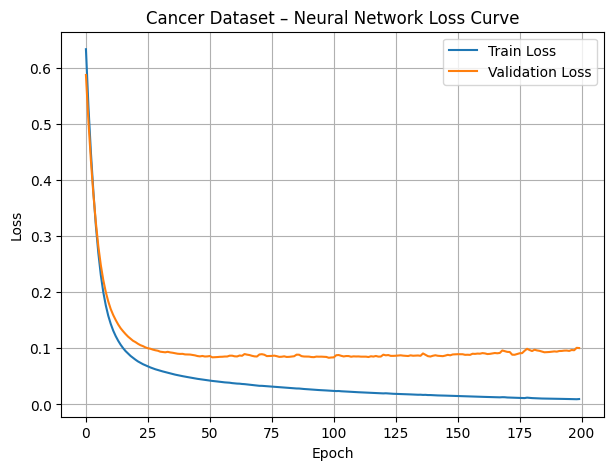


=== Neural Network Performance ===
Accuracy : 0.9561
Precision: 0.9855
Recall   : 0.9444
F1 Score : 0.9645

=== MODEL COMPARISON (Validation Set) ===
Model                   Acc   Prec    Rec     F1
--------------------------------------------------
Neural Net            0.956  0.986  0.944  0.965
Logistic Reg.         0.982  0.986  0.986  0.986
SVM (RBF)             0.982  0.986  0.986  0.986


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim

# Load Cancer dataset
data = load_breast_cancer()
X = data.data.astype(np.float32)
y = data.target.astype(np.int64)

print("Breast Cancer dataset shape:", X.shape)
print("Classes (0 = malignant, 1 = benign):", np.bincount(y))

#  Train-Test Split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

#  Convert to PyTorch Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32).to(device)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32).to(device)

#  Neural Network Model
class CancerNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 20),   # One hidden layer
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

model = CancerNet(X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#  Training Loop
num_epochs = 200
batch_size = 32
train_losses = []
val_losses   = []

def get_batches(X, y, batch_size):
    idx = np.random.permutation(len(X))
    for start in range(0, len(X), batch_size):
        end = start + batch_size
        batch_idx = idx[start:end]
        yield X[batch_idx], y[batch_idx]

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_train_loss = 0

    for xb_np, yb_np in get_batches(X_train, y_train, batch_size):
        xb = torch.tensor(xb_np, dtype=torch.float32).to(device)
        yb = torch.tensor(yb_np, dtype=torch.float32).unsqueeze(1).to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * xb.size(0)

    epoch_train_loss /= len(X_train)

    # validation loss
    model.eval()
    with torch.no_grad():
        logits_val = model(X_val_t)
        val_loss = criterion(logits_val, y_val_t.unsqueeze(1)).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{num_epochs}   Train Loss: {epoch_train_loss:.4f}   Val Loss: {val_loss:.4f}")

#  Plot Training vs Validation Loss
plt.figure(figsize=(7,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Validation Loss')
plt.title('Cancer Dataset – Neural Network Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#  Evaluate Neural Network
model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(X_val_t)).cpu().numpy().ravel()
y_pred_nn = (probs >= 0.5).astype(int)

acc_nn  = accuracy_score(y_val, y_pred_nn)
prec_nn = precision_score(y_val, y_pred_nn)
rec_nn  = recall_score(y_val, y_pred_nn)
f1_nn   = f1_score(y_val, y_pred_nn)

print("\n=== Neural Network Performance ===")
print(f"Accuracy : {acc_nn:.4f}")
print(f"Precision: {prec_nn:.4f}")
print(f"Recall   : {rec_nn:.4f}")
print(f"F1 Score : {f1_nn:.4f}")

#  Logistic Regression & SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Logistic Regression
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_val)

acc_log  = accuracy_score(y_val, y_pred_log)
prec_log = precision_score(y_val, y_pred_log)
rec_log  = recall_score(y_val, y_pred_log)
f1_log   = f1_score(y_val, y_pred_log)

# SVM (RBF kernel)
svm = SVC(kernel='rbf', probability=False)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)

acc_svm  = accuracy_score(y_val, y_pred_svm)
prec_svm = precision_score(y_val, y_pred_svm)
rec_svm  = recall_score(y_val, y_pred_svm)
f1_svm   = f1_score(y_val, y_pred_svm)

# Display Comparison Table
print("\n=== MODEL COMPARISON (Validation Set) ===")
print(f"{'Model':<20} {'Acc':>6} {'Prec':>6} {'Rec':>6} {'F1':>6}")
print("-"*50)
print(f"{'Neural Net':<20} {acc_nn:6.3f} {prec_nn:6.3f} {rec_nn:6.3f} {f1_nn:6.3f}")
print(f"{'Logistic Reg.':<20} {acc_log:6.3f} {prec_log:6.3f} {rec_log:6.3f} {f1_log:6.3f}")
print(f"{'SVM (RBF)':<20} {acc_svm:6.3f} {prec_svm:6.3f} {rec_svm:6.3f} {f1_svm:6.3f}")
